In [ ]:
import matplotlib.pyplot as plt #https://matplotlib.org/stable/plot_types/index.html documentación
import numpy as np
from scipy.signal import find_peaks
import pandas as pd
from scipy.optimize import curve_fit #https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
from scipy import odr
from google.colab import drive
drive.mount('/content/drive')
from numpy import linspace, array,zeros,arange,append,nan
from numpy import linspace, array, zeros, arange, append, nan, tan, sqrt, pi, cos, sin, exp
from scipy import linalg, optimize


import matplotlib.pyplot as plt
from IPython.display import Latex
from ipywidgets import interactive
#from IPython.display import FloatSliderWidget, IntSliderWidget
#from Ipython.html import widgets
#from IPython.html.widgets import FloatSliderWidget, IntSliderWidget
%pylab inline --no-import-all
import numpy as np
import pandas as pd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Populating the interactive namespace from numpy and matplotlib


# **TIA-cianinas**

In [ ]:
# ==== Ajuste para las tia (.txt) ====

# Definimos la doble gaussiana
def doble_gaussiana(x, A0, mu0, sigma0, A1, mu1, sigma1, y0):
    return A0 * np.exp(- (x - mu0)**2 / (2 * sigma0**2)) + A1 * np.exp(- (x - mu1)**2 / (2 * sigma1**2)) + y0


# Definimos la funcion del ajuste
def run_fit_curvefit(filename, x_min, x_max, p0, bounds, y_offset=0, y_scale=1):
    datos = pd.read_csv(filename, sep='\t', skiprows=1, quotechar='"')
    datos.columns = datos.columns.str.strip()  # Eliminar espacios en encabezados
    print("Columnas detectadas:", datos.columns.tolist())

    # Buscar nombres posibles de columnas
    posibles_nombres = {
        'wavelength': None,
        'abs': None
    }
    for col in datos.columns:
        col_lower = col.lower()
        if 'wave' in col_lower:
            posibles_nombres['wavelength'] = col
        if 'abs' in col_lower:
            posibles_nombres['abs'] = col

    if posibles_nombres['wavelength'] is None or posibles_nombres['abs'] is None:
        raise KeyError("No se encontraron columnas con 'wave' y 'abs'.")

    l = datos[posibles_nombres['wavelength']]
    absorb = datos[posibles_nombres['abs']]

    # Filtrar rango
    mask = (l >= x_min) & (l <= x_max)
    xdata = l[mask].to_numpy()
    ydata = absorb[mask].to_numpy()

    # Normalización
    ydata = (ydata + y_offset) / y_scale

    # Ajuste con curve_fit
    params_opt, cov = curve_fit(doble_gaussiana, xdata, ydata, p0=p0, bounds=bounds)
    errors = np.sqrt(np.diag(cov))

    mu0 = params_opt[1]
    mu1 = params_opt[4]
    y_mu0 = doble_gaussiana(mu0, *params_opt)
    y_mu1 = doble_gaussiana(mu1, *params_opt)
    sigma0 = params_opt[2]
    sigma1 = params_opt[5]

    # Mostrar parámetros
    print("\nParámetros ajustados:")
    nombres = ["A0", "mu0", "sigma0", "A1", "mu1", "sigma1", "y0"]
    for i, (val, err) in enumerate(zip(params_opt, errors)):
        print(f"{nombres[i]} = {val:.4f} ± {err:.4f}")

    print(f"\nAbsorbancia en mu0 = {mu0:.2f} nm: {y_mu0:.4f}")
    print(f"Absorbancia en mu1 = {mu1:.2f} nm: {y_mu1:.4f}")

    # Calcular R²
    y_fit = doble_gaussiana(xdata, *params_opt)
    ss_res = np.sum((ydata - y_fit) ** 2)
    ss_tot = np.sum((ydata - np.mean(ydata)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)

    # Gráfica
    x_fit = np.linspace(min(xdata), max(xdata), 1000)
    y_fit = doble_gaussiana(x_fit, *params_opt)

    plt.figure(figsize=(8, 5))
    plt.plot(xdata, ydata, label='Datos experimentales')
    plt.scatter(xdata, ydata, color='blue')
    plt.plot(x_fit, y_fit, label='Ajuste doble gaussiana', color='red')
    plt.xlabel('Longitud de onda ($nm$)', fontsize=18)
    plt.ylabel('Absorbancia', fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.axvline(x=mu0, linestyle='--', color='black', label=f"$\\lambda_1$ = {mu0:.1f}(2) $nm$")
    plt.axvline(x=mu1, linestyle='--', color='black', label=f"$\\lambda_2$ = {mu1:.0f}(6) $nm$")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
      "parametros": params_opt,
      "errores": errors,
      "mu0": mu0,
      "mu1": mu1,
      "sigma0": sigma0,
      "sigma1": sigma1,
      "y_mu0": y_mu0,
      "y_mu1": y_mu1,
      "R2": r_squared,
      }

### DTTC

Columnas detectadas: ['Wavelength nm.', 'Abs.']

Parámetros ajustados:
A0 = 0.6565 ± 0.0480
mu0 = 762.9687 ± 0.2488
sigma0 = 20.3939 ± 0.5391
A1 = 0.4640 ± 0.2269
mu1 = 712.0312 ± 5.8879
sigma1 = 65.6825 ± 24.4239
y0 = 0.0000 ± 0.2204

Absorbancia en mu0 = 762.97 nm: 1.0000
Absorbancia en mu1 = 712.03 nm: 0.4930


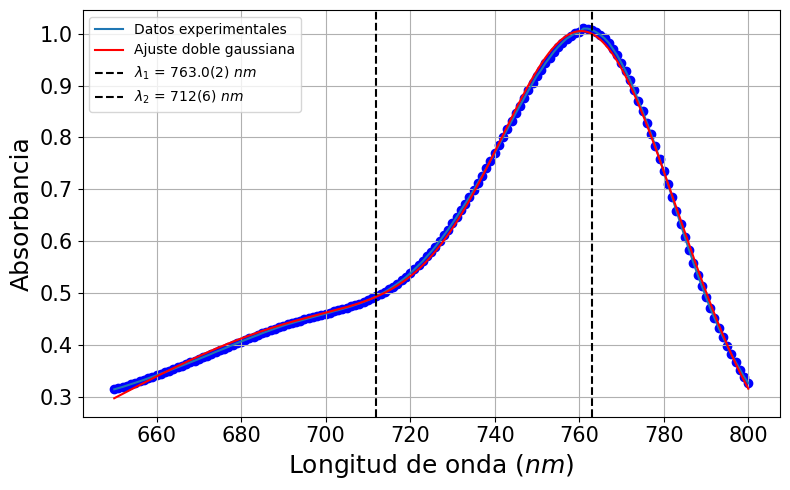


Cociente I1/I0 = 3.2132
R² del ajuste = 0.9991


In [ ]:
# carga de datos y rango del ajuste
filename = '/content/drive/MyDrive/EC/TP1/TIA-cianinas/File_250827_163657.txt'
x_min = 650
x_max = 800

# Parametros iniciales [A0, mu0, sigma0, A1, mu1, sigma1, y0]
p0 = [1, 760, 20, 0.5, 700, 40, 0]

# Límites de parámetros
bounds = (
    [0.4, 750, 10, 0, 690, 20, -0.5],
    [3, 770, 30, 1.2, 720, 70, 0.5]
)

# Normalización (realizada a traves de un primer ajuste)
y_offset = 0.3883
y_scale = 2.2813

# Ejecutar ajuste
resultado = run_fit_curvefit(filename, x_min, x_max, p0, bounds, y_offset, y_scale)

# Calcular cociente I1/I0
params_opt = resultado["parametros"]
mu0_dttc = resultado["mu0"]
mu1_dttc = resultado["mu1"]
sigma0_dttc = resultado["sigma0"]
sigma1_dttc = resultado["sigma1"]
y_mu0_dttc = resultado["y_mu0"]
y_mu1_dttc = resultado["y_mu1"]


cociente = 10**(y_mu0_dttc - y_mu1_dttc)

print(f"\nCociente I1/I0 = {cociente:.4f}")
print(f"R² del ajuste = {resultado['R2']:.4f}")

### DTDC

Columnas detectadas: ['Wavelength nm.', 'Abs.']

Parámetros ajustados:
A0 = 0.8569 ± 0.0183
mu0 = 655.7331 ± 0.0893
sigma0 = 15.0502 ± 0.1429
A1 = 0.3256 ± 0.0075
mu1 = 617.6631 ± 1.4551
sigma1 = 29.6919 ± 1.2529
y0 = 0.0000 ± 0.0044

Absorbancia en mu0 = 655.73 nm: 1.0000
Absorbancia en mu1 = 617.66 nm: 0.3605


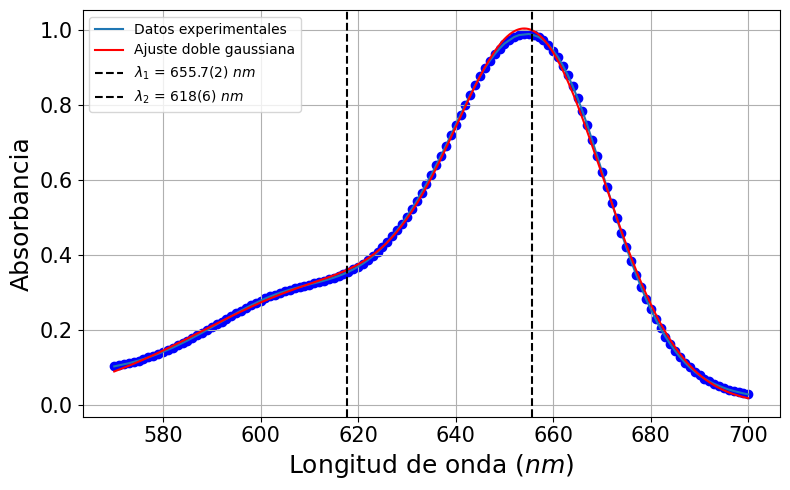


Cociente I1/I0 = 4.3597
R² del ajuste = 0.9993


In [ ]:
# carga de datos y rango del ajuste
filename = '/content/drive/MyDrive/EC/TP1/TIA-cianinas/File_250827_161311.txt'
x_min = 570
x_max = 700

# Parametros iniciales [A0, mu0, sigma0, A1, mu1, sigma1, y0]
p0 = [1, 660, 10, 0.5, 610, 20, 0]

# Límites de parámetros
bounds = (
        [0.4, 650, 0, 0, 600, 10, -0.5],
        [3, 670, 20, 1.2, 620, 30, 0.5]
    )

# Normalización (realizada a traves de un primer ajuste)
y_offset = 0.0025
y_scale = 2.8669

# Ejecutar ajuste
resultado = run_fit_curvefit(filename, x_min, x_max, p0, bounds, y_offset, y_scale)

# Calcular cociente I1/I0
params_opt = resultado["parametros"]
mu0_dtdc = resultado["mu0"]
mu1_dtdc = resultado["mu1"]
sigma0_dtdc = resultado["sigma0"]
sigma1_dtdc = resultado["sigma1"]
y_mu0_dtdc = resultado["y_mu0"]
y_mu1_dtdc = resultado["y_mu1"]


cociente = 10**(y_mu0_dtdc - y_mu1_dtdc)

print(f"\nCociente I1/I0 = {cociente:.4f}")
print(f"R² del ajuste = {resultado['R2']:.4f}")

### DTCI

Columnas detectadas: ['Wavelength nm.', 'Abs.']

Parámetros ajustados:
A0 = 0.7927 ± 0.0311
mu0 = 559.9628 ± 0.0953
sigma0 = 10.0392 ± 0.2077
A1 = 0.4456 ± 0.0124
mu1 = 533.1272 ± 1.3099
sigma1 = 21.6972 ± 1.1819
y0 = 0.0000 ± 0.0069

Absorbancia en mu0 = 559.96 nm: 1.0001
Absorbancia en mu1 = 533.13 nm: 0.4679


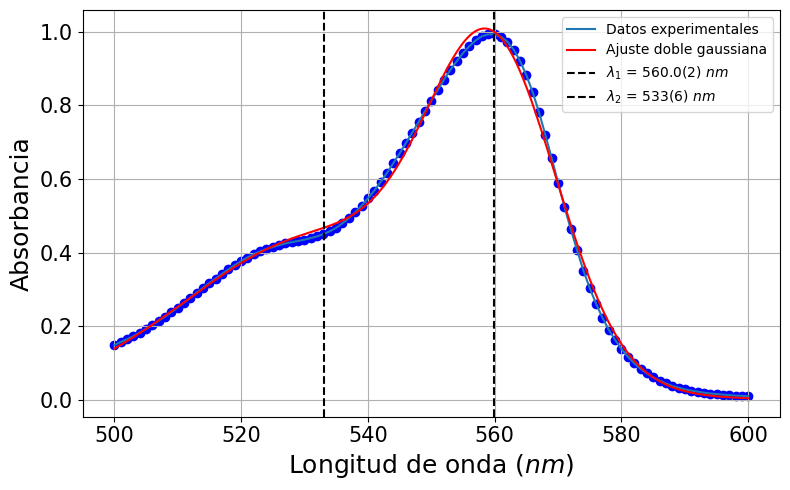


Cociente I1/I0 = 3.4056
R² del ajuste = 0.9979


In [ ]:
# carga de datos y rango del ajuste
filename = '/content/drive/MyDrive/EC/TP1/TIA-cianinas/File_250827_160523.txt'
x_min = 500
x_max = 600

# Parametros iniciales [A0, mu0, sigma0, A1, mu1, sigma1, y0]
p0 = [1, 560, 10, 0.5, 525, 20, 0]

# Límites de parámetros
bounds = (
        [0.4, 555, 0, 0, 520, 10, -0.5],
        [1.5, 565, 20, 1.2, 535, 25, 0.5]
    )

# Normalización (realizada a traves de un primer ajuste)
y_offset = 0.0083
y_scale = 0.5068

# Ejecutar ajuste
resultado = run_fit_curvefit(filename, x_min, x_max, p0, bounds, y_offset, y_scale)

# Calcular cociente I1/I0
params_opt = resultado["parametros"]
mu0_dtci = resultado["mu0"]
mu1_dtci = resultado["mu1"]
sigma0_dtci = resultado["sigma0"]
sigma1_dtci = resultado["sigma1"]
y_mu0_dtci = resultado["y_mu0"]
y_mu1_dtci = resultado["y_mu1"]

I0 = doble_gaussiana(mu0_dtci, *params_opt)
I1 = doble_gaussiana(mu1_dtci, *params_opt)
cociente = 10**(y_mu0_dtci - y_mu1_dtci)

print(f"\nCociente I1/I0 = {cociente:.4f}")
print(f"R² del ajuste = {resultado['R2']:.4f}")

# **OXO-cininas**


In [ ]:
# ==== Ajuste para las oxo (.csv) ====

# Función doble gaussiana
def doble_gaussiana_csv(x, A0, mu0, sigma0, A1, mu1, sigma1, y0):
    return (
        A0 * np.exp(- (x - mu0)**2 / (2 * sigma0**2))
        + A1 * np.exp(- (x - mu1)**2 / (2 * sigma1**2))
        + y0
    )


# Versión para archivos CSV
def run_fit_curvefit_csv(filename, x_min, x_max, p0, bounds, y_offset=0, y_scale=1):

    datos = pd.read_csv(filename, sep=',', quotechar='"', skipinitialspace=True, header=1)

    # Limpiar nombres de columnas
    datos.columns = datos.columns.str.strip().str.replace('"', '')

    print("Columnas detectadas:", datos.columns.tolist())

    l = datos['Wavelength']
    absorb = datos['Abs']

    # Rango de análisis
    mask = (l >= x_min) & (l <= x_max)
    xdata = l[mask].to_numpy()
    ydata = absorb[mask].to_numpy()

    # Normalización
    ydata = (ydata + y_offset) / y_scale

    # Ajuste
    params_opt, cov = curve_fit(doble_gaussiana_csv, xdata, ydata, p0=p0, bounds=bounds)
    errors = np.sqrt(np.diag(cov))

    mu0 = params_opt[1]
    mu1 = params_opt[4]
    y_mu0 = doble_gaussiana_csv(mu0, *params_opt)
    y_mu1 = doble_gaussiana_csv(mu1, *params_opt)
    sigma0 = params_opt[2]
    sigma1 = params_opt[5]

    # Imprimir parámetros
    print("\nParámetros ajustados:")
    nombres = ["A0", "mu0", "sigma0", "A1", "mu1", "sigma1", "y0"]
    for i, (val, err) in enumerate(zip(params_opt, errors)):
        print(f"{nombres[i]} = {val:.4f} ± {err:.4f}")

    print(f"\nAbsorbancia en mu0 = {mu0:.2f} nm: {y_mu0:.4f}")
    print(f"Absorbancia en mu1 = {mu1:.2f} nm: {y_mu1:.4f}")

    # Calcular R²
    y_fit = doble_gaussiana_csv(xdata, *params_opt)
    ss_res = np.sum((ydata - y_fit) ** 2)
    ss_tot = np.sum((ydata - np.mean(ydata)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)

    # Gráfico
    x_fit = np.linspace(min(xdata), max(xdata), 1000)
    y_fit = doble_gaussiana_csv(x_fit, *params_opt)

    plt.figure(figsize=(8, 5))
    plt.plot(xdata, ydata, label='Datos experimentales')
    plt.scatter(xdata, ydata, color='blue')
    plt.plot(x_fit, y_fit, label='Ajuste doble gaussiana', color='red')
    plt.xlabel('Longitud de onda ($nm$)', fontsize=18)
    plt.ylabel('Absorbancia', fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.axvline(x=mu0, linestyle='--', color='black', label=f"$\\lambda_1$ = {mu0:.1f}(2) $nm$")
    plt.axvline(x=mu1, linestyle='--', color='black', label=f"$\\lambda_2$ = {mu1:.0f}(6) $nm$")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Retornar resultados
    return {
      "parametros": params_opt,
      "errores": errors,
      "mu0": mu0,
      "mu1": mu1,
      "sigma0": sigma0,
      "sigma1": sigma1,
      "y_mu0": y_mu0,
      "y_mu1": y_mu1,
      "R2": r_squared,
      }

### DOCI

Columnas detectadas: ['Wavelength', 'Abs', 'Unnamed: 2']

Parámetros ajustados:
A0 = 0.6956 ± 0.0197
mu0 = 486.7539 ± 0.0895
sigma0 = 7.7377 ± 0.1698
A1 = 0.6000 ± 0.0079
mu1 = 465.0386 ± 0.5634
sigma1 = 18.6415 ± 0.4048
y0 = 0.0000 ± 0.0028

Absorbancia en mu0 = 486.75 nm: 1.0000
Absorbancia en mu1 = 465.04 nm: 0.6136


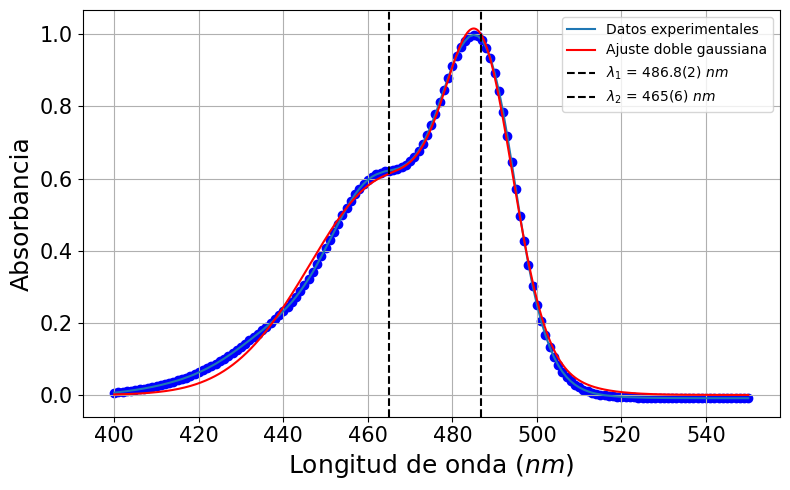


Cociente I1/I0 = 2.4347

Cociente 2 I1/I0 = 0.6136
R² del ajuste = 0.9971


In [ ]:
# carga de datos y rango del ajuste
filename = '/content/drive/MyDrive/EC/TP1/Oxocianinas/DO-CI.csv'
x_min = 400
x_max = 550

# Parametros iniciales [A0, mu0, sigma0, A1, mu1, sigma1, y0]
p0 = [1, 485, 15, 0.5, 460, 15, 0]

# Límites de parámetros
bounds = (
        [0.4, 480, 0, 0, 450 , 5, -0.5],
        [1.5, 490, 20, 1.2, 475, 20, 0.5]
    )

# Normalización (realizada a traves de un primer ajuste)
y_offset = -0.0188
y_scale = 1.8904

# Ejecutar ajuste
resultado = run_fit_curvefit_csv(filename, x_min, x_max, p0, bounds, y_offset, y_scale)

# Calcular cociente I1/I0
params_opt = resultado["parametros"]
mu0_doci = resultado["mu0"]
mu1_doci = resultado["mu1"]
sigma0_doci = resultado["sigma0"]
sigma1_doci = resultado["sigma1"]
y_mu0_doci = resultado["y_mu0"]
y_mu1_doci = resultado["y_mu1"]

I0 = doble_gaussiana(mu0_doci, *params_opt)
I1 = doble_gaussiana(mu1_doci, *params_opt)
cociente = 10**(y_mu0_doci - y_mu1_doci)
cociente2 = y_mu1_doci / y_mu0_doci

print(f"\nCociente I1/I0 = {cociente:.4f}")
print(f"\nCociente 2 I1/I0 = {cociente2:.4f}")
print(f"R² del ajuste = {resultado['R2']:.4f}")

### DODC

Columnas detectadas: ['Wavelength', 'Abs', 'Unnamed: 2']

Parámetros ajustados:
A0 = 0.9255 ± 0.0095
mu0 = 583.6950 ± 0.1120
sigma0 = 12.6758 ± 0.0820
A1 = 0.3180 ± 0.0035
mu1 = 549.6247 ± 0.6707
sigma1 = 20.0000 ± 0.4723
y0 = 0.0000 ± 0.0011

Absorbancia en mu0 = 583.69 nm: 1.0000
Absorbancia en mu1 = 549.62 nm: 0.3430


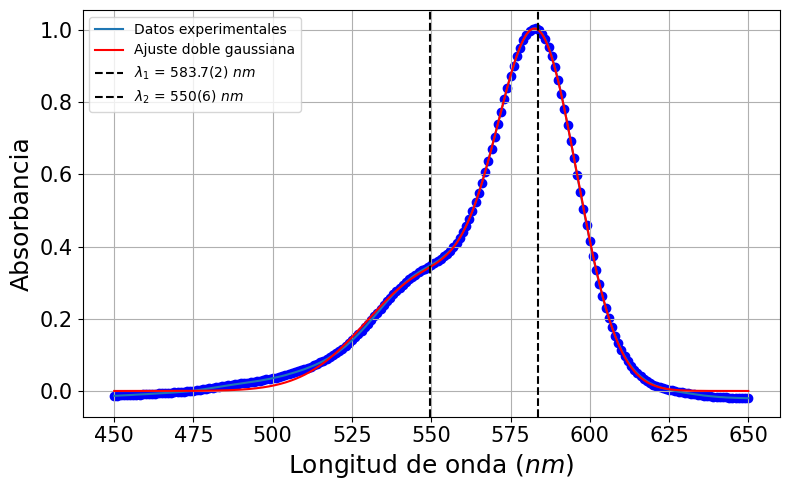


Cociente I1/I0 = 4.5392

Cociente 2 I1/I0 = 0.3430
R² del ajuste = 0.9990


In [ ]:
# carga de datos y rango del ajuste
filename = '/content/drive/MyDrive/EC/TP1/Oxocianinas/DO-DC.csv'
x_min = 450
x_max = 650

# Parametros iniciales [A0, mu0, sigma0, A1, mu1, sigma1, y0]
p0 = [1, 583, 10, 0.5, 550, 10, 0]

# Límites de parámetros
bounds = (
        [0, 580, 0, 0, 540 , 0, -0.1],
        [2, 590, 20, 10, 560 + 20, 20, 0.2]
    )

# Normalización (realizada a traves de un primer ajuste)
y_offset = -0.0244
y_scale = 0.9956

# Ejecutar ajuste
resultado = run_fit_curvefit_csv(filename, x_min, x_max, p0, bounds, y_offset, y_scale)

# Calcular cociente I1/I0
params_opt = resultado["parametros"]
mu0_dodc = resultado["mu0"]
mu1_dodc = resultado["mu1"]
sigma0_dodc = resultado["sigma0"]
sigma1_dodc = resultado["sigma1"]
y_mu0_dodc = resultado["y_mu0"]
y_mu1_dodc = resultado["y_mu1"]

I0 = doble_gaussiana(mu0_dodc, *params_opt)
I1 = doble_gaussiana(mu1_dodc, *params_opt)
cociente = 10**(y_mu0_dodc - y_mu1_dodc)
cociente2 = y_mu1_dodc / y_mu0_dodc

print(f"\nCociente I1/I0 = {cociente:.4f}")
print(f"\nCociente 2 I1/I0 = {cociente2:.4f}")
print(f"R² del ajuste = {resultado['R2']:.4f}")

### DOTC

Columnas detectadas: ['Wavelength', 'Abs', 'Unnamed: 2']

Parámetros ajustados:
A0 = 0.7998 ± 0.0165
mu0 = 655.0279 ± 0.1386
sigma0 = 17.0263 ± 0.2251
A1 = 0.6740 ± 0.0099
mu1 = 595.3964 ± 0.4422
sigma1 = 38.5215 ± 1.1920
y0 = -0.0028 ± 0.0102

Absorbancia en mu0 = 655.03 nm: 1.0003
Absorbancia en mu1 = 595.40 nm: 0.6729


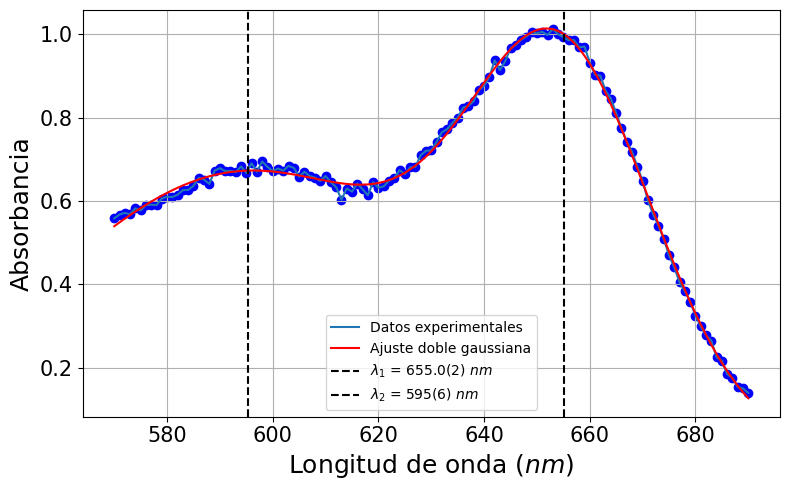


Cociente I1/I0 = 2.1254

Cociente 2 I1/I0 = 0.6727
R² del ajuste = 0.9973


In [ ]:
# carga de datos y rango del ajuste
filename = '/content/drive/MyDrive/EC/TP1/Oxocianinas/DO-TC.csv'
x_min = 570
x_max = 690

# Parametros iniciales [A0, mu0, sigma0, A1, mu1, sigma1, y0]
p0 = [1, 655, 17, 0.5, 595, 38, -0.02]

# Límites de parámetros
bounds = (
        [0, 640, 1, 0, 585, 1, -0.03],
        [10, 665 + 10, 100, 10, 605, 50, 0.03]
    )

# Normalización (realizada a traves de un primer ajuste)
y_offset = 0.0181
y_scale = 0.0084

# Ejecutar ajuste
resultado = run_fit_curvefit_csv(filename, x_min, x_max, p0, bounds, y_offset, y_scale)

# Calcular cociente I1/I0
params_opt = resultado["parametros"]
mu0_dotc = resultado["mu0"]
mu1_dotc = resultado["mu1"]
sigma0_dotc = resultado["sigma0"]
sigma1_dotc = resultado["sigma1"]
y_mu0_dotc = resultado["y_mu0"]
y_mu1_dotc = resultado["y_mu1"]

I0 = doble_gaussiana(mu0_dotc, *params_opt)
I1 = doble_gaussiana(mu1_dotc, *params_opt)
cociente = 10**(y_mu0_dotc - y_mu1_dotc)
cociente2 = y_mu1_dotc / y_mu0_dotc

print(f"\nCociente I1/I0 = {cociente:.4f}")
print(f"\nCociente 2 I1/I0 = {cociente2:.4f}")
print(f"R² del ajuste = {resultado['R2']:.4f}")

### Todas juntas

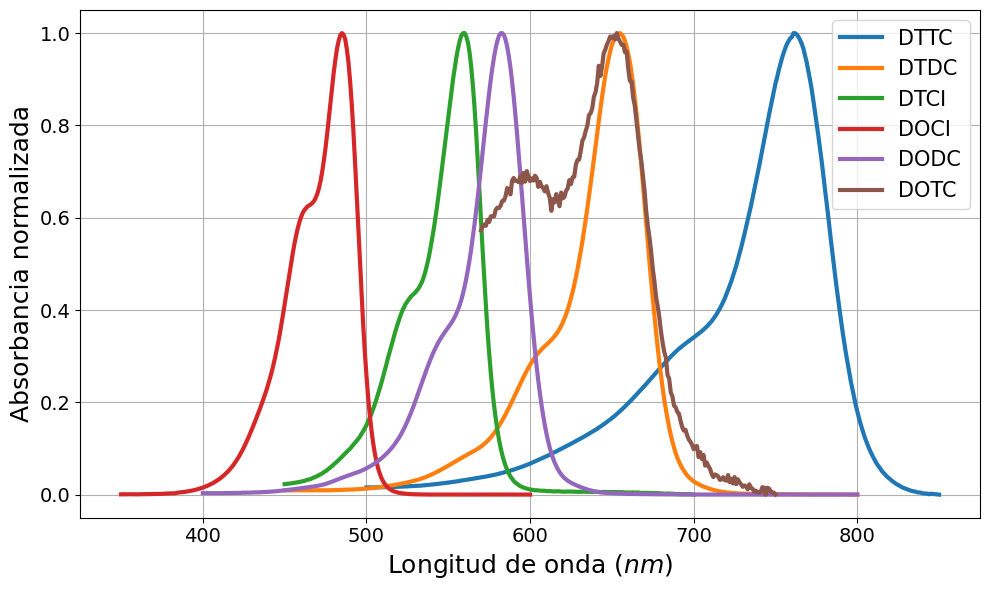

In [ ]:
def cargar_y_normalizar(path, rango, label):
    datos = pd.read_csv(path, sep='\t' if path.endswith('.txt') else ',', skiprows=1, quotechar='"')
    datos.columns = datos.columns.str.strip()

    # Detectar columnas automáticamente
    posibles_nombres = {'wavelength': None, 'abs': None}
    for col in datos.columns:
        col_lower = col.lower()
        if 'wave' in col_lower:
            posibles_nombres['wavelength'] = col
        if 'abs' in col_lower:
            posibles_nombres['abs'] = col


    l = datos[posibles_nombres['wavelength']]
    absorb = datos[posibles_nombres['abs']]

    # Filtrar por rango
    mask = (l >= rango[0]) & (l <= rango[1])
    x = l[mask].to_numpy()
    y = absorb[mask].to_numpy()

    # Normalizar: mínimo en 0, máximo en 1
    y_norm = y - y.min()
    if y_norm.max() != 0:
        y_norm = y_norm / y_norm.max()

    return x, y_norm, label

# Lista de datasets
datasets = [
    {
        'label': 'DTTC',
        'path': '/content/drive/MyDrive/EC/TP1/TIA-cianinas/File_250827_163657.txt',
        'rango': (500, 850)
    },
    {
        'label': 'DTDC',
        'path': '/content/drive/MyDrive/EC/TP1/TIA-cianinas/File_250827_161311.txt',
        'rango': (450, 800)
    },
    {
        'label': 'DTCI',
        'path': '/content/drive/MyDrive/EC/TP1/TIA-cianinas/File_250827_160523.txt',
        'rango': (450, 700)
    },
    {
        'label': 'DOCI',
        'path': '/content/drive/MyDrive/EC/TP1/Oxocianinas/DO-CI.csv',
        'rango': (350, 600)
    },
    {
        'label': 'DODC',
        'path': '/content/drive/MyDrive/EC/TP1/Oxocianinas/DO-DC.csv',
        'rango': (400, 950)
    },
    {
        'label': 'DOTC',
        'path': '/content/drive/MyDrive/EC/TP1/Oxocianinas/DO-TC.csv',
        'rango': (570, 750)
    },
]

plt.figure(figsize=(10, 6))
for ds in datasets:
    x, y, label = cargar_y_normalizar(ds['path'], ds['rango'], ds['label'])
    plt.plot(x, y, label=label, linewidth=3)

plt.xlabel("Longitud de onda ($nm$)", fontsize=18)
plt.ylabel("Absorbancia normalizada", fontsize=18)
plt.legend(fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


# Pozo infinito


In [ ]:
mus=[mu0_dtci, mu0_dtdc,mu0_dttc,mu0_doci,mu0_dodc,mu0_dotc]
print(mus)

[np.float64(559.9628450325359), np.float64(655.733145236497), np.float64(762.9686692432587), np.float64(486.75388482170007), np.float64(583.6949680299327), np.float64(655.0278949233394)]


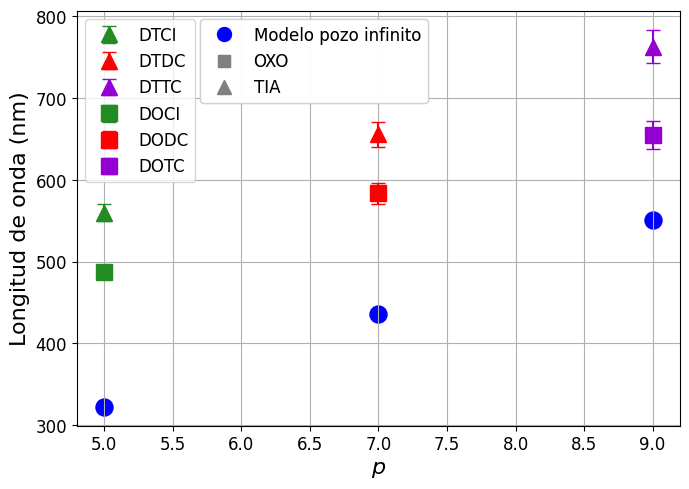

In [ ]:
# Datos
mus = [mu0_dtci, mu0_dtdc, mu0_dttc, mu0_doci, mu0_dodc, mu0_dotc]
sigmas = [sigma0_dtci, sigma0_dtdc, sigma0_dttc, sigma0_doci, sigma0_dodc, sigma0_dotc]
pt = [5,7,9,5,7,9]
nombres1 = ["DTCI", "DTDC", "DTTC","DOCI", "DODC", "DOTC" ]
colores1 = ['forestgreen', "red", "darkviolet", 'forestgreen', "red", "darkviolet"]
formas1 = ["^", "^","^","s", "s", "s" ]
pt1 = [5,7,9]

# Constantes
d = 0.134  # distancia de enlace c-c tipica (nm)
m = 9.10938356e-31 # masa electron (kg)
h = 6.62607015e-34 # Planck (Js)
c = 2.99792458e8   # velocidad de la luz (m/s)
a = 8 * m * c / h   # en m^-1
a = a * 1e-9        # convertir a nm^-1

# Función modelo
def f(i, a, d):
    return a * (((i + 2) * d) ** 2) / (i + 4)

puntos_modelo = [f(i, a, d) for i in pt1]

# Crear figura y ejes
fig, ax = plt.subplots(figsize=(7,5))

# Graficar datos experimentales con barras de error
for x, y, nombre, color, err, forma in zip(pt, mus, nombres1, colores1, sigmas, formas1):
    ax.errorbar(x, y, yerr=err, color=color, fmt=forma, capsize=5,
                markersize=12, label=nombre)

# Graficar modelo
modelo_scatter = ax.scatter(pt1, puntos_modelo,
                            color="blue", marker="o", s=150)

ax.plot(pt1, puntos_modelo, linestyle="",markersize=20, color="blue")  # solo puntos, sin label adicional

# Primera leyenda: datos + modelo
handles1, labels1 = ax.get_legend_handles_labels()
leg1 = ax.legend(handles=handles1, loc="upper left", title="", fontsize=12)
ax.add_artist(leg1)

# Dummy plots para leyenda separada (símbolos explicativos)
dummy1 = ax.plot([], [], color="grey", marker="s", linestyle="", markersize=8, label="OXO")[0]
dummy2 = ax.plot([], [], color="grey", marker="^", linestyle="", markersize=10, label="TIA")[0]
dummy3 = ax.plot([], [], color="b", marker="o", linestyle="", markersize=10, label="Modelo pozo infinito")[0]

# Segunda leyenda: solo dummy
leg2 = ax.legend(handles=[dummy3, dummy1, dummy2], loc="upper center", bbox_to_anchor=(0.393, 1), title="", fontsize=12)
ax.add_artist(leg2)

# Labels y título
ax.set_xlabel("$p$", fontsize=16)
ax.set_ylabel("Longitud de onda (nm)", fontsize=16)
ax.set_title("", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True)

plt.tight_layout()
plt.show()


#Pozo extendido

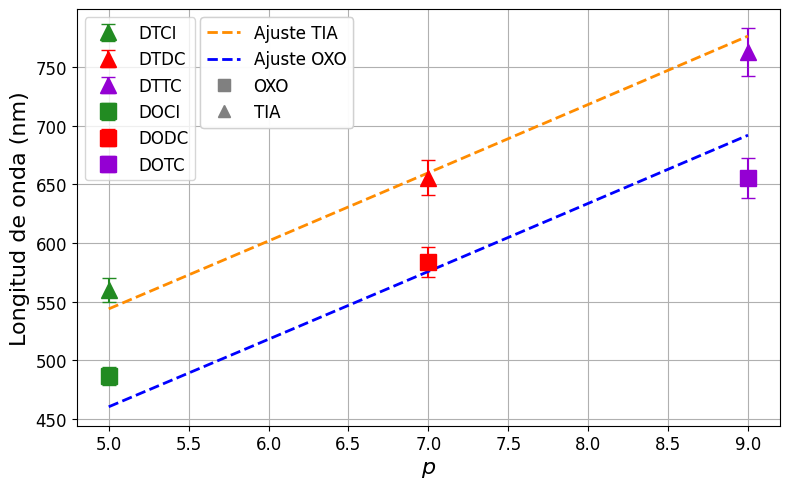

Longitud de TIA: 0.5180760476380392 ± 0.020253660265309163
Longitud de OXO: 0.32395541424550733 ± 0.04327659788616845
R² TIA: 0.977711633285322
R² OXO: 0.8510286236909709
[np.float64(486.75388482170007), np.float64(583.6949680299327), np.float64(655.0278949233394)]
[np.float64(559.9628450325359), np.float64(655.733145236497), np.float64(762.9686692432587)]
[np.float64(7.737719397602653), np.float64(12.675835970255656), np.float64(17.026265401927205)]
[np.float64(10.039175212898085), np.float64(15.050181562973597), np.float64(20.39390695258219)]


In [ ]:
# Datos
mu_t = [mu0_dtci, mu0_dtdc, mu0_dttc]
mu_o = [mu0_doci, mu0_dodc, mu0_dotc]
p = np.array([5,7,9])
sigma_t = [sigma0_dtci, sigma0_dtdc, sigma0_dttc]
sigma_o = [sigma0_doci, sigma0_dodc, sigma0_dotc]
nombres_t = ["DTCI", "DTDC", "DTTC"]
colores_t = ['forestgreen', "red", "darkviolet"]
formas_t = ["^", "^","^"]

nombres_o = ["DOCI", "DODC", "DOTC"]
colores_o = ['forestgreen', "red", "darkviolet"]
formas_o = ["s", "s","s"]

# Modelo a ajustar
def funcion1(A, x):
    d = 0.134  # nm
    return 3.3e3 * (((x + 2) * d + A[0])**2) / (x + 4 + A[0] / d)

lineal1 = odr.Model(funcion1)

# Ajuste primer conjunto
A0_inicial = 0.0001
datos1 = odr.RealData(p, mu_t, sy=sigma_t)
myodr1 = odr.ODR(datos1, lineal1, beta0=[A0_inicial])
fit_result1 = myodr1.run()
a1 = fit_result1.beta[0]

# Ajuste segundo conjunto
datos2 = odr.RealData(p, mu_o, sy=sigma_o)
myodr2 = odr.ODR(datos2, lineal1, beta0=[A0_inicial])
fit_result2 = myodr2.run()
a2 = fit_result2.beta[0]

# Crear figura y ejes
fig, ax = plt.subplots(figsize=(8,5))

# Graficar datos experimentales TIA
for x, y, nombre, color, err, forma in zip(p, mu_t, nombres_t, colores_t, sigma_t, formas_t):
    ax.errorbar(x, y, yerr=err, fmt=forma, color=color, capsize=5,
                markersize=12, label=nombre)

# Graficar datos experimentales OXO
for x, y, nombre, color, err, forma in zip(p, mu_o, nombres_o, colores_o, sigma_o, formas_o):
    ax.errorbar(x, y, yerr=err, fmt=forma, color=color, capsize=5,
                markersize=12, label=nombre)

fit_result1.sd_beta[0]  # error de a1
fit_result2.sd_beta[0]  # error de a2

# Curvas ajustadas
pmin = np.min(p)
pmax = np.max(p)

p_fit = np.linspace(pmin, pmax, 200)

linea1, = ax.plot(p_fit, funcion1([a1], p_fit), '--', color="darkorange",
         linewidth=2)
linea2, = ax.plot(p_fit, funcion1([a2], p_fit), '--', color="blue",
         linewidth=2)

# Primera leyenda: datos + ajustes
handles1, labels1 = ax.get_legend_handles_labels()
leg1 = ax.legend(handles=handles1, loc='upper left', bbox_to_anchor=(0,1), fontsize=12, title="")
ax.add_artist(leg1)

# Dummy plots para leyenda explicativa
dummy1 = ax.plot([], [], color="grey", marker="s", linestyle="", markersize=8, label="OXO")[0]
dummy2 = ax.plot([], [], color="grey", marker="^", linestyle="", markersize=8, label="TIA")[0]
dummy3 = ax.plot([], [], color="darkorange", linestyle="--", linewidth=2, label="Ajuste TIA")[0]
dummy4 = ax.plot([], [], color="blue", linestyle="--", linewidth=2, label="Ajuste OXO")[0]
# Segunda leyenda: solo dummy
leg2 = ax.legend(handles=[dummy3, dummy4, dummy1, dummy2], loc='upper right', bbox_to_anchor=(0.4045, 1),
                 fontsize=12, title="")
ax.add_artist(leg2)

# Etiquetas y título
ax.set_xlabel('$p$', fontsize=16)
ax.set_ylabel(r'Longitud de onda (nm)', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True)
plt.tight_layout()
plt.show()
print("Longitud de TIA:", a1, "±", fit_result1.sd_beta[0])
print("Longitud de OXO:", a2, "±", fit_result2.sd_beta[0])

# Función para calcular R^2
def r_squared(y_data, y_fit):
    residuals = y_data - y_fit
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_data - np.mean(y_data))**2)
    return 1 - ss_res/ss_tot

# Valores ajustados para cada conjunto
y_fit_t = funcion1([a1], p)
y_fit_o = funcion1([a2], p)

# R^2
R2_t = r_squared(mu_t, y_fit_t)
R2_o = r_squared(mu_o, y_fit_o)

print("R² TIA:", R2_t)
print("R² OXO:", R2_o)

print(mu_o)
print(mu_t)
print(sigma_o)
print(sigma_t)


Chi^2 Pozo Infinito: 59675.19211071457
Chi^2 Pozo Infinito Extendido: 2125.2841306432138
Chi^2 Pozo Finito: 2641.927513523726


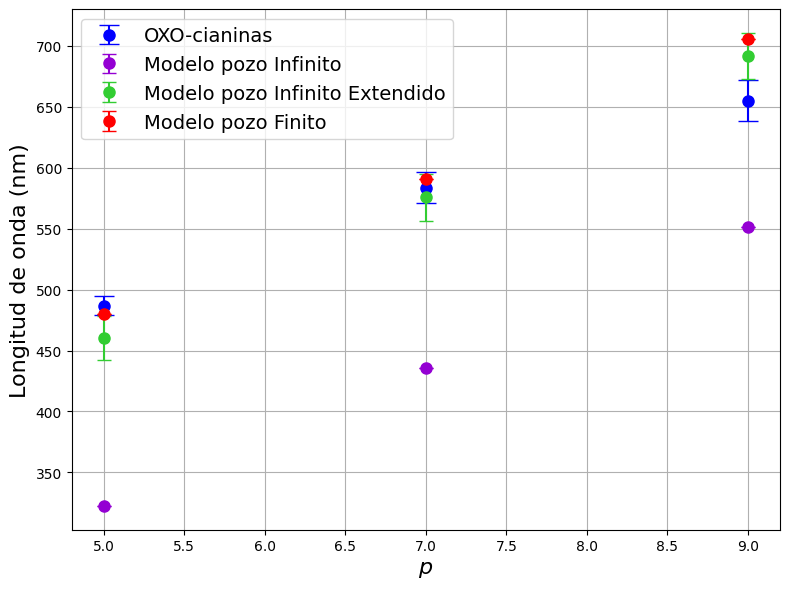

In [ ]:
# Datos experimentales
p = [5, 7, 9]
lambda_oxo_exp = mu_o
#[486.75, 583.69, 655]  # Longitudes de onda experimentales
err_oxo_exp = sigma_o  # Errores experimentales

# Datos pozo infinito
lambda_oxo_pozo_inf = [322.33, 435.95, 551.05]  # Longitudes de onda pozo infinito
err_oxo_pozo_inf = [0, 0, 0]  # Errores pozo infinito (son cero)

# Datos pozo infinito extendido
lambda_oxo_pozo_inf_ext = [460.29, 575.70, 691.92]  # Longitudes de onda pozo infinito extendido
err_oxo_pozo_inf_ext = [18, 19, 19]  # Errores pozo infinito extendido

# Datos pozo finito
lambda_oxo_pozo_fin = [479.68, 591.08, 705.40]  # Longitudes de onda pozo finito
err_oxo_pozo_fin = [0, 0, 0]  # Errores pozo finito (no sabemos)

# Crear figura y ejes
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar Set 1: Resultados experimentales
ax.errorbar(p, lambda_oxo_exp, yerr=err_oxo_exp, fmt='o', color='blue', capsize=7,
            markersize=8, label="OXO-cianinas", linestyle="")

# Graficar Set 2: Pozo Infinito
ax.errorbar(p, lambda_oxo_pozo_inf, yerr=err_oxo_pozo_inf, fmt='o', color='darkviolet', capsize=5,
            markersize=8, label="Modelo pozo Infinito", linestyle="")

# Graficar Set 3: Pozo Infinito Extendido
ax.errorbar(p, lambda_oxo_pozo_inf_ext, yerr=err_oxo_pozo_inf_ext, fmt='o', color='limegreen', capsize=5,
            markersize=8, label="Modelo pozo Infinito Extendido", linestyle="")

# Graficar Set 4: Pozo Finito
ax.errorbar(p, lambda_oxo_pozo_fin, yerr=err_oxo_pozo_fin, fmt='o', color='red', capsize=5,
            markersize=8, label="Modelo pozo Finito", linestyle="")

# Función para calcular chi^2
def chi2(obs, exp, err):
    obs = np.array(obs, dtype=float)
    exp = np.array(exp, dtype=float)
    err = np.array(err, dtype=float)
    return np.sum(((obs - exp))**2)

# Calcular chi^2 de cada modelo respecto a los datos experimentales
chi2_pozo_inf = chi2(lambda_oxo_pozo_inf, lambda_oxo_exp, err_oxo_exp)
chi2_pozo_inf_ext = chi2(lambda_oxo_pozo_inf_ext, lambda_oxo_exp, err_oxo_exp)
chi2_pozo_fin = chi2(lambda_oxo_pozo_fin, lambda_oxo_exp, err_oxo_exp)

print("Chi^2 Pozo Infinito:", chi2_pozo_inf)
print("Chi^2 Pozo Infinito Extendido:", chi2_pozo_inf_ext)
print("Chi^2 Pozo Finito:", chi2_pozo_fin)


# Ajustes finales de la gráfica
ax.set_xlabel('$p$', fontsize=16)
ax.set_ylabel('Longitud de onda (nm)', fontsize=16)
ax.legend(fontsize=14)
ax.grid(True)

# Mostrar la gráfica
plt.tight_layout()
plt.show()


Chi^2 Pozo Infinito: 149623.17580000003
Chi^2 Pozo Infinito Extendido: 467.9128999999997
Chi^2 Pozo Finito: 0.6082000000000806


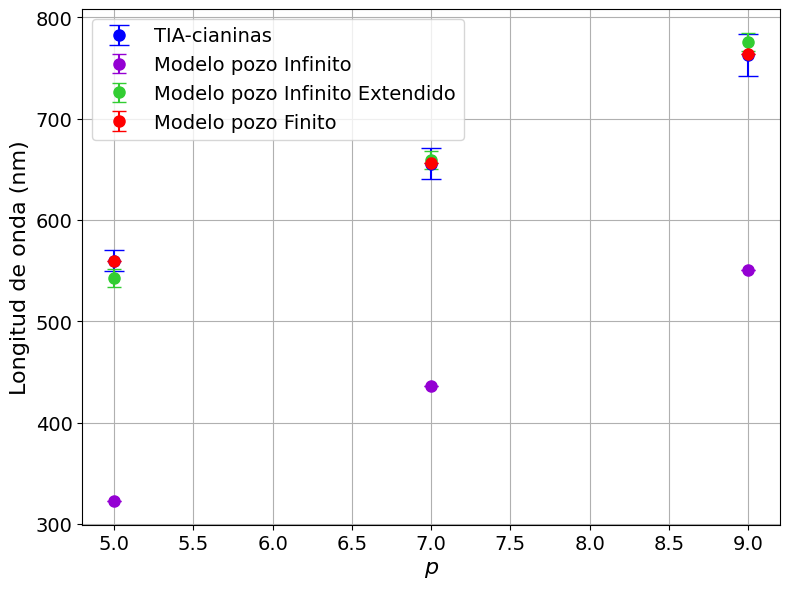

In [27]:
# Datos experimentales
p = [5, 7, 9]
lambda_tia_exp = [559.9, 655.73, 762.9]  # Longitudes de onda experimentales
err_tia_exp = sigma_t  # Errores experimentales

# Datos pozo infinito
lambda_tia_pozo_inf = [322.33, 435.95, 551.05]  # Longitudes de onda pozo infinito
err_tia_pozo_inf = [0, 0, 0]  # Errores pozo infinito

# Datos pozo infinito extendido
lambda_tia_pozo_inf_ext = [543, 659, 776]  # Longitudes de onda pozo infinito extendido
err_tia_pozo_inf_ext = [9, 9, 9]  # Errores pozo infinito extendido


# Datos pozo finito
lambda_tia_pozo_fin = [559.54, 655.78, 763.59]  # Longitudes de onda pozo finito
err_tia_pozo_fin = [0.00, 0.00, 0.00]  # Errores pozo finito (son cero)

# Crear figura y ejes
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar Set 1: Resultados experimentales
ax.errorbar(p, lambda_tia_exp, yerr=err_tia_exp, fmt='o', color='blue', capsize=7,
            markersize=8, label="TIA-cianinas", linestyle="")

# Graficar Set 2: Pozo Infinito
ax.errorbar(p, lambda_tia_pozo_inf, yerr=err_tia_pozo_inf, fmt='o', color='darkviolet', capsize=5,
            markersize=8, label="Modelo pozo Infinito", linestyle="")

# Graficar Set 3: Pozo Infinito Extendido
ax.errorbar(p, lambda_tia_pozo_inf_ext, yerr=err_tia_pozo_inf_ext, fmt='o', color='limegreen', capsize=5,
            markersize=8, label="Modelo pozo Infinito Extendido", linestyle="")

# Graficar Set 4: Pozo Finito
ax.errorbar(p, lambda_tia_pozo_fin, yerr=err_tia_pozo_fin, fmt='o', color='red', capsize=5,
            markersize=8, label="Modelo pozo Finito", linestyle="")



# Función para calcular chi^2
def chi2(obs, exp, err):
    obs = np.array(obs, dtype=float)
    exp = np.array(exp, dtype=float)
    err = np.array(err, dtype=float)
    return np.sum(((obs - exp))**2)

# Calcular chi^2 de cada modelo respecto a los datos experimentales
chi2_pozo_inf = chi2(lambda_tia_pozo_inf, lambda_tia_exp, err_oxo_exp)
chi2_pozo_inf_ext = chi2(lambda_tia_pozo_inf_ext, lambda_tia_exp, err_oxo_exp)
chi2_pozo_fin = chi2(lambda_tia_pozo_fin, lambda_tia_exp, err_oxo_exp)

print("Chi^2 Pozo Infinito:", chi2_pozo_inf)
print("Chi^2 Pozo Infinito Extendido:", chi2_pozo_inf_ext)
print("Chi^2 Pozo Finito:", chi2_pozo_fin)


# Ajustes finales de la gráfica
ax.set_xlabel('$p$', fontsize=16)
ax.set_ylabel('Longitud de onda (nm)', fontsize=16)
ax.legend(fontsize=14)
ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=14)
# Mostrar la gráfica
plt.tight_layout()
plt.show()
